In [ ]:
# -*- coding: utf-8 -*-
import os
import time
import shutil
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.models import convnext_tiny
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
# STEP 1: Authenticate with GCS
from google.colab import files
uploaded = files.upload()  # Upload your GCS JSON key file

json_filename = list(uploaded.keys())[0]
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = json_filename
print(f"Authenticated using: {json_filename}")

# STEP 2: Download dataset from GCS
GCS_URI = "gs://onion11"
!mkdir -p OnionData
!gsutil -m cp -r {GCS_URI}/* OnionData/

Streaming output truncated to the last 5000 lines.
Copying gs://onion11/BR_E5_P3_S_0582_FEB_7.JPG...
Copying gs://onion11/BR_E5_P3_S_0582_FEB_7.txt...
Copying gs://onion11/BR_E5_P3_S_0583_FEB_7.JPG...
Copying gs://onion11/BR_E5_P3_S_0583_FEB_7.txt...
Copying gs://onion11/BR_E5_P3_S_0694__FEB_8.JPG...
Copying gs://onion11/BR_E5_P3_S_0694__FEB_8.txt...
Copying gs://onion11/BR_E5_P3_S_0695__FEB_8.JPG...
Copying gs://onion11/BR_E5_P3_S_0695__FEB_8.txt...
Copying gs://onion11/BR_E5_P3_S_0735_FEB_9.JPG...
Copying gs://onion11/BR_E5_P3_S_0736_FEB_9.JPG...
Copying gs://onion11/BR_E5_P3_S_0735_FEB_9.txt...
Copying gs://onion11/BR_E5_P3_S_0736_FEB_9.txt...
Copying gs://onion11/BR_E5_P3_S_0787__FEB_14.JPG...
Copying gs://onion11/BR_E5_P3_S_0787__FEB_14.txt...
Copying gs://onion11/BR_E5_P3_S_0788__FEB_14.JPG...
Copying gs://onion11/BR_E5_P3_S_0788__FEB_14.txt...
Copying gs://onion11/BR_E5_P3_S_0832__FEB_14.JPG...
Copying gs://onion11/BR_E5_P3_S_0832__FEB_14.txt...
Copying gs://onion11/BR_E5_P3_S_0

In [ ]:
# STEP 3: Organize data into train, val, test folders
base_dir = 'OnionData'
jpgs = {os.path.splitext(f)[0]: f for f in os.listdir(base_dir) if f.endswith('.jpg')}
txts = {os.path.splitext(f)[0]: f for f in os.listdir(base_dir) if f.endswith('.txt')}
paired = [base for base in jpgs if base in txts]

class_id_to_name = {}
class_txt = os.path.join(base_dir, 'classes.txt')
if os.path.exists(class_txt):
    with open(class_txt, 'r') as f:
        for i, line in enumerate(f):
            class_id_to_name[str(i)] = line.strip()

class_to_images = {}
for base in paired:
    txt_path = os.path.join(base_dir, txts[base])
    try:
        with open(txt_path, 'r') as f:
            line = f.readline().strip()
            class_id = line.split()[0]
            class_label = class_id_to_name.get(class_id, f"class_{class_id}")
            class_to_images.setdefault(class_label, []).append(jpgs[base])
    except:
        continue

for split in ['train', 'val', 'test']:
    shutil.rmtree(split, ignore_errors=True)
    for label in class_to_images:
        os.makedirs(os.path.join(split, label), exist_ok=True)

for label, images in class_to_images.items():
    random.shuffle(images)
    total = len(images)
    train_n = int(0.8 * total)
    val_n = int(0.1 * total)

    for img in images[:train_n]:
        shutil.copy(os.path.join(base_dir, img), os.path.join('train', label, img))
    for img in images[train_n:train_n+val_n]:
        shutil.copy(os.path.join(base_dir, img), os.path.join('val', label, img))
    for img in images[train_n+val_n:]:
        shutil.copy(os.path.join(base_dir, img), os.path.join('test', label, img))


In [ ]:
# STEP 4: Data Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('train', transform=transform)
val_dataset = datasets.ImageFolder('val', transform=transform)
test_dataset = datasets.ImageFolder('test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)
print("Detected classes:", train_dataset.classes)

Detected classes: ['Anthracnose', 'Basal_Rot', 'Iris_Yellow_Spot_Virus', 'Purple_Blotch', 'Stemphylium_Blight', 'Thrips']


In [ ]:
# STEP 5: Define ConvNeXt Model
class PlantDiseaseModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = convnext_tiny(pretrained=True)
        self.model.classifier[2] = nn.Linear(768, num_classes)

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PlantDiseaseModel(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 203MB/s] 


In [ ]:
# STEP 6: Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    start = time.time()
    train_acc, val_acc, train_loss, val_loss = [], [], [], []

    for epoch in range(epochs):
        model.train()
        correct, total, loss_sum = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_acc.append(100 * correct / total)
        train_loss.append(loss_sum / len(train_loader))

        # Validation
        model.eval()
        correct, total, loss_sum = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss_sum += loss.item()
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        val_acc.append(100 * correct / total)
        val_loss.append(loss_sum / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc[-1]:.2f}%, Val Acc: {val_acc[-1]:.2f}%")

    duration = time.time() - start
    return train_acc, val_acc, train_loss, val_loss, duration

train_acc, val_acc, train_loss, val_loss, training_time = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs=10
)

Epoch 1/10, Train Acc: 72.29%, Val Acc: 77.36%
Epoch 2/10, Train Acc: 78.41%, Val Acc: 77.36%
Epoch 3/10, Train Acc: 81.18%, Val Acc: 82.08%
Epoch 4/10, Train Acc: 87.76%, Val Acc: 81.13%
Epoch 5/10, Train Acc: 89.84%, Val Acc: 69.81%
Epoch 6/10, Train Acc: 88.68%, Val Acc: 76.42%
Epoch 7/10, Train Acc: 87.53%, Val Acc: 83.02%
Epoch 8/10, Train Acc: 92.15%, Val Acc: 85.85%
Epoch 9/10, Train Acc: 88.11%, Val Acc: 82.08%
Epoch 10/10, Train Acc: 92.38%, Val Acc: 86.79%


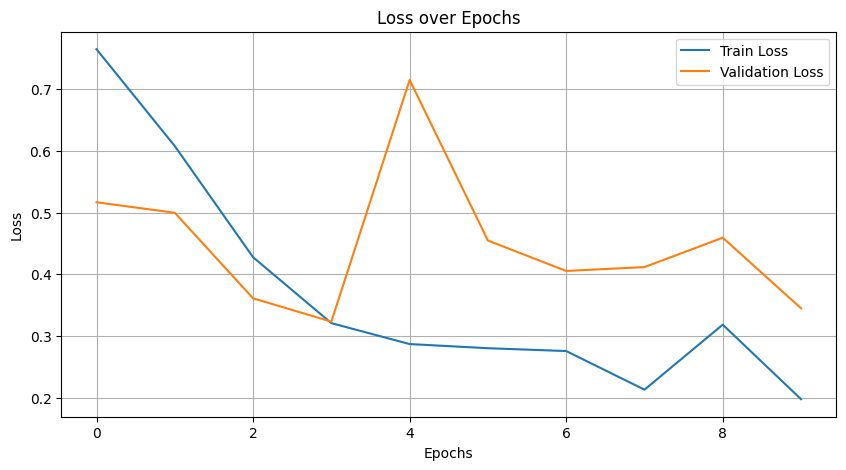

In [ ]:
# STEP 7: Plot Loss Curve
plt.figure(figsize=(10,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# STEP 8: Test Accuracy
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
test_acc = 100 * correct / total

# STEP 9: Model Size & Summary
model_size = sum(p.numel() for p in model.parameters()) * 4 / (1024**2)
print("\n--- Model Summary ---")
print(f"Training Accuracy: {train_acc[-1]:.2f}%")
print(f"Validation Accuracy: {val_acc[-1]:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Model Size: {model_size:.2f} MB")


--- Model Summary ---
Training Accuracy: 92.38%
Validation Accuracy: 86.79%
Test Accuracy: 84.96%
Training Time: 2089.30 seconds
Model Size: 106.14 MB



Classification Report:
                        precision    recall  f1-score   support

           Anthracnose       0.76      1.00      0.86        31
             Basal_Rot       1.00      0.50      0.67         2
Iris_Yellow_Spot_Virus       1.00      1.00      1.00        25
         Purple_Blotch       0.38      0.50      0.43        10
    Stemphylium_Blight       1.00      0.20      0.33        15
                Thrips       1.00      1.00      1.00        30

              accuracy                           0.84       113
             macro avg       0.86      0.70      0.72       113
          weighted avg       0.88      0.84      0.82       113



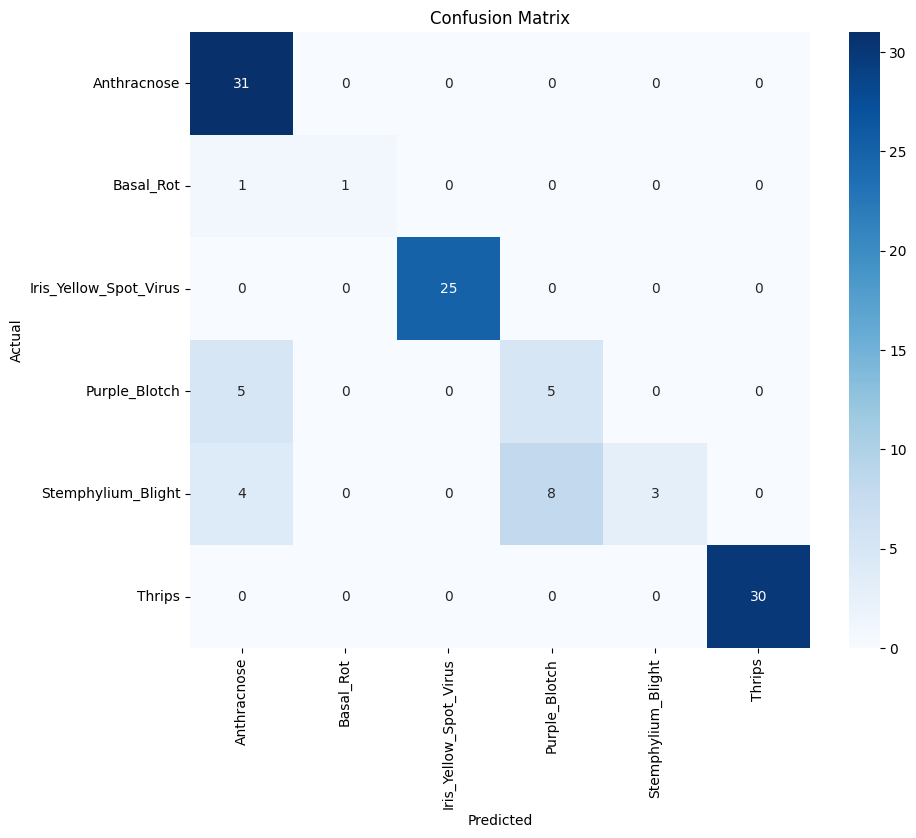


AUC-ROC Curves:


<ipython-input-9-061715a20a1d>:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_classes)


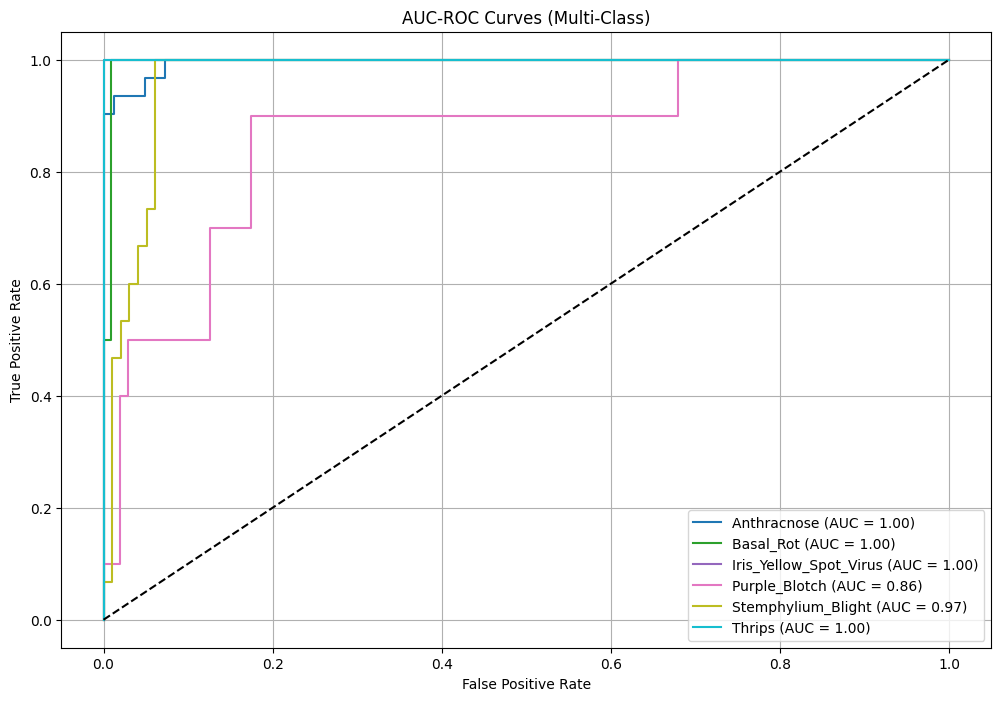

In [ ]:
# STEP 10: Classification Report, Confusion Matrix, ROC AUC
all_labels, all_preds, all_probs = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(outputs.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# AUC-ROC
print("\nAUC-ROC Curves:")
y_bin = label_binarize(all_labels, classes=list(range(num_classes)))
fpr, tpr, roc_auc = {}, {}, {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap("tab10", num_classes)
for i, color in zip(range(num_classes), colors.colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f"{train_dataset.classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curves (Multi-Class)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()